# cwinsor's Kaggle PLAsTiCC


### The Plan:

Feature Engineering (Libraries I want to use highest priority first):
* feets (feature extractor for timeseries) - community contribution, starting with astronomical features
* cesium (feature extractor/explorer for timeseries) - general timeseries library with web app
* lomb-scargle
* catboost (library for categorical data)
* george 
* bayes

Modeling:  Machine learning techniqus I want to use:
* LightGBM
* stacking/ensemble

The general approach is:
1. for each object, segment the timeseries into observation chunks (use "feets" for this)




In [1]:
import pandas as pd
import numpy as np
import gc
import os

* there are:
  * [test/train]_set_metadata
  * [test/train]_set
  * test_set_sample - a small (1M lines of test data)
  * sample_submission - example submission file

```

            Training                 "Test"                  aggregated     Validation
            ---------------------    -----------------       -----------    ------------

metadata    training_set_metadata    test_set_metadata 
            (7800 x 12)              (3.4M x 11)
 (btrotta)  "train_meta"             "test_meta"             "all_meta"


timeseries  training_set             test_set_samples        "xxx"
            (1.4M x 6)               (1.0M x 6)
 (btrotta)  "train"                  "test"

                                     (poorly named "Test"
                                     it is unlabeled data)
```


In [2]:
shared_data_path = r'C:\\Users\\Chris\\Documents\\code_kaggle_plasticc___shared_data\\PLAsTiCC-2018'

In [3]:
# read training data
col_dict = {'mjd': np.float64, 'flux': np.float32, 'flux_err': np.float32, 'object_id': np.int32, 'passband': np.int8,
            'detected': np.int8}
train_meta = pd.read_csv(os.path.join(shared_data_path, 'training_set_metadata.csv'))
train = pd.read_csv(os.path.join(shared_data_path, 'training_set.csv'), dtype=col_dict)


In [4]:
# read test data
test_meta = pd.read_csv(os.path.join(shared_data_path, 'test_set_metadata.csv'))
test = pd.read_csv(os.path.join(shared_data_path, 'test_set_sample.csv'), dtype=col_dict)

In [5]:
# we observe test_set_metadata has many IDs that are not in the test_set_samples
print(train_meta.shape)
print(train.shape)
print(test_meta.shape)
print(test.shape)
# and the number of unique IDs in test data is much smaller
print(train_meta["object_id"].unique().shape)
print(train["object_id"].unique().shape)
print(test_meta["object_id"].unique().shape)
print(test["object_id"].unique().shape)

(7848, 12)
(1421705, 6)
(3492890, 11)
(1000000, 6)
(7848,)
(7848,)
(3492890,)
(3036,)


In [6]:
# so create a test_meta_sub that contains only those IDs where there is accompanying data in test
unique = test['object_id'].unique()
criteria = test_meta['object_id'].isin(unique)
test_meta_sub = test_meta[criteria]

In [7]:
test_meta_sub

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv
0,13,34.453125,-5.229529,169.987075,-59.956185,1,0.3048,0.3193,0.0542,41.1123,0.019
1,14,33.398438,-4.331149,167.226341,-59.936551,1,NaN,0.6323,0.0179,42.8774,0.018
2,17,348.529419,-61.755440,321.293980,-51.763351,1,NaN,0.8297,0.0605,43.6000,0.016
3,23,34.804688,-5.829153,171.307861,-60.174401,1,NaN,0.6533,0.1479,42.9640,0.023
4,34,351.321442,-64.198746,317.458993,-50.429931,1,0.4557,0.4617,0.0122,42.0540,0.023
...,...,...,...,...,...,...,...,...,...,...,...
3031,32267,351.953644,-62.132156,318.777388,-52.347124,1,0.4967,0.5030,0.0106,42.2768,0.019
3032,32269,53.789062,-27.784405,223.685697,-53.845803,1,0.3181,0.4847,0.4165,42.1803,0.009
3033,32284,52.207031,-28.630989,224.800211,-55.343637,1,NaN,1.1842,0.0852,44.5544,0.009
3034,32293,2.457983,-45.389202,324.632685,-69.945696,1,NaN,0.6675,0.1017,43.0207,0.011


# investigate a bit

In [8]:
# there is some discussion that training and test are very different (galactic vs extra-galactic)
# I want to see (distribution of) distmod for training, test
# I want to see (correlation of) hostgal_photoz and distmod for training, test
# I want to see (correlation of) hostgal_spez) and distmod for training, test

In [9]:
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
#%matplotlib inline

In [10]:
train_meta['distmod'].hist

<bound method hist_series of 0           NaN
1       45.4063
2       40.2561
3       40.7951
4       40.4166
         ...   
7843        NaN
7844    46.6108
7845        NaN
7846        NaN
7847        NaN
Name: distmod, Length: 7848, dtype: float64>

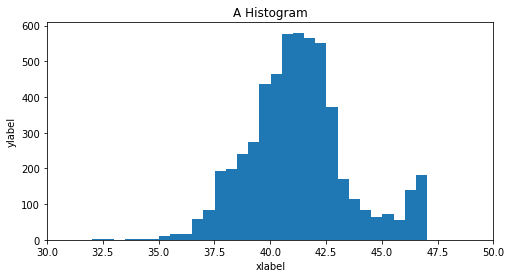

In [12]:
f = plt.figure(figsize = (8, 4))
plt.title('A Histogram')
plt.xlabel('xlabel')
plt.ylabel('ylabel')
plt.xlim(30, 50)
y = plt.hist(figure=f, x=train_meta['distmod'], bins = 30)

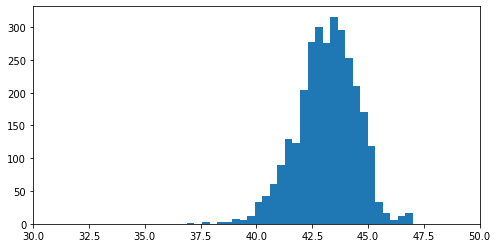

In [13]:
f = plt.figure(figsize = (8, 4))
plt.xlim(30, 50)
y = plt.hist(figure=f, x=test_meta_sub['distmod'], bins = 30)

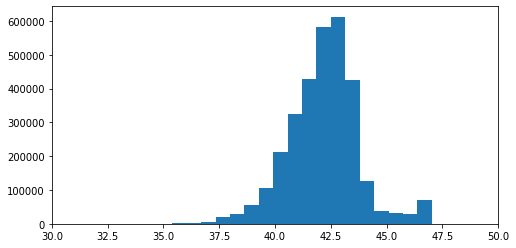

In [14]:
f = plt.figure(figsize = (8, 4))
plt.xlim(30, 50)
y = plt.hist(figure=f, x=test_meta['distmod'], bins = 30)

### in conclusion - the test data is somewhat different from train

## now lets look at correlation between distmod and hostgal_spez/photoz

In [15]:
train_meta

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90
...,...,...,...,...,...,...,...,...,...,...,...,...
7843,130739978,26.718750,-14.940303,172.342697,-72.255675,0,0.0000,0.0000,0.0000,NaN,0.013,65
7844,130755807,120.101349,-62.696659,275.742955,-16.509746,0,0.1725,2.5606,1.1146,46.6108,0.136,90
7845,130762946,203.108109,-55.682144,308.728904,6.727511,0,0.0000,0.0000,0.0000,NaN,0.430,16
7846,130772921,79.101562,-35.501846,239.172243,-33.827844,0,0.0000,0.0000,0.0000,NaN,0.034,65


In [16]:
foo = train_meta[train_meta['object_id']<1000]
foo

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90


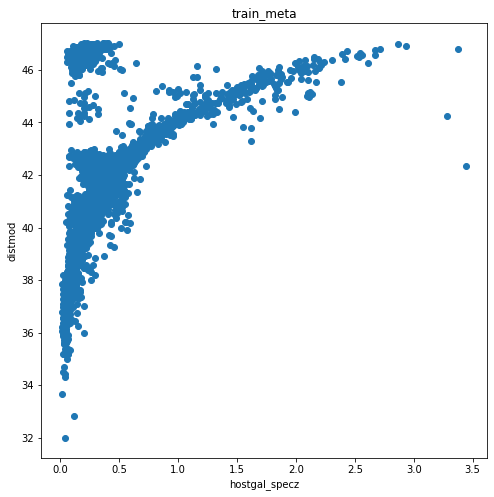

In [17]:
f = plt.figure(figsize = (8, 8))
plt.title('train_meta')
plt.xlabel('hostgal_specz')
plt.ylabel('distmod')
y = plt.scatter(x=train_meta['hostgal_specz'],
                y=train_meta['distmod'])

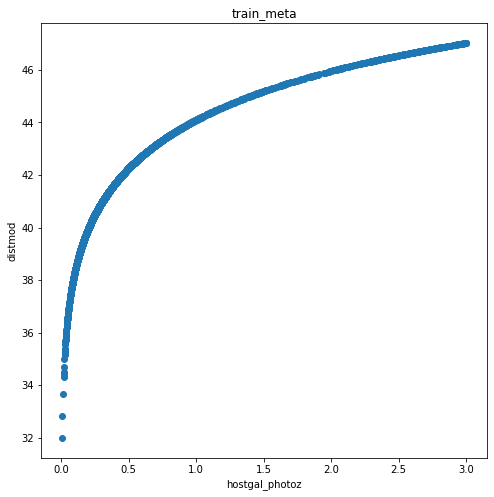

In [18]:
f = plt.figure(figsize = (8, 8))
plt.title('train_meta')
plt.xlabel('hostgal_photoz')
plt.ylabel('distmod')
y = plt.scatter(x=train_meta['hostgal_photoz'],
                y=train_meta['distmod'])

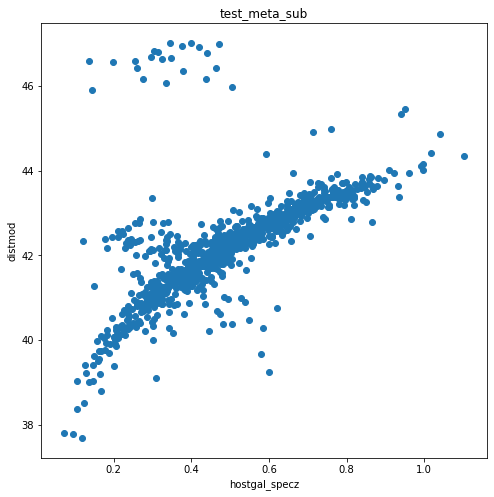

In [19]:
f = plt.figure(figsize = (8, 8))
plt.title('test_meta_sub')
plt.xlabel('hostgal_specz')
plt.ylabel('distmod')
y = plt.scatter(x=test_meta_sub['hostgal_specz'],
                y=test_meta_sub['distmod'])

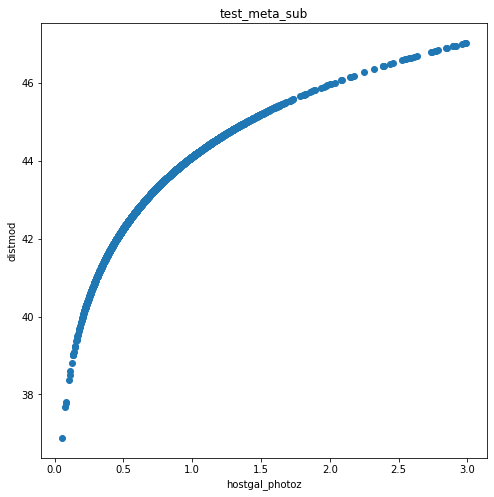

In [20]:
f = plt.figure(figsize = (8, 8))
plt.title('test_meta_sub')
plt.xlabel('hostgal_photoz')
plt.ylabel('distmod')
y = plt.scatter(x=test_meta_sub['hostgal_photoz'],
                y=test_meta_sub['distmod'])

# feature creation...

In [21]:
# cesium
# play with cesium a bit
import cesium as cesium

# For each of the 14 classes, how many objects are in the dataset...

In [22]:

print(train_meta[train_meta["target"]==92].shape)
print(train_meta[train_meta["target"]==88].shape)
print(train_meta[train_meta["target"]==42].shape)
print(train_meta[train_meta["target"]==90].shape)
print(train_meta[train_meta["target"]==65].shape)
print(train_meta[train_meta["target"]==16].shape)
print(train_meta[train_meta["target"]==67].shape)
print(train_meta[train_meta["target"]==95].shape)
print(train_meta[train_meta["target"]==62].shape)
print(train_meta[train_meta["target"]==15].shape)
print(train_meta[train_meta["target"]==52].shape)
print(train_meta[train_meta["target"]==6].shape)
print(train_meta[train_meta["target"]==64].shape)
print(train_meta[train_meta["target"]==53].shape)

(239, 12)
(370, 12)
(1193, 12)
(2313, 12)
(981, 12)
(924, 12)
(208, 12)
(175, 12)
(484, 12)
(495, 12)
(183, 12)
(151, 12)
(102, 12)
(30, 12)


In [32]:
# for class 92 - investigate the first object...
class_id = 92
object_num = 0
objects_df = train_meta[train_meta["target"]==class_id]
#objects_df
object_df = objects_df.iloc[object_num]
object_df

object_id             615.000000
ra                    349.046051
decl                  -61.943836
gal_l                 320.796530
gal_b                 -51.753706
ddf                     1.000000
hostgal_specz           0.000000
hostgal_photoz          0.000000
hostgal_photoz_err      0.000000
distmod                      NaN
mwebv                   0.017000
target                 92.000000
Name: 0, dtype: float64

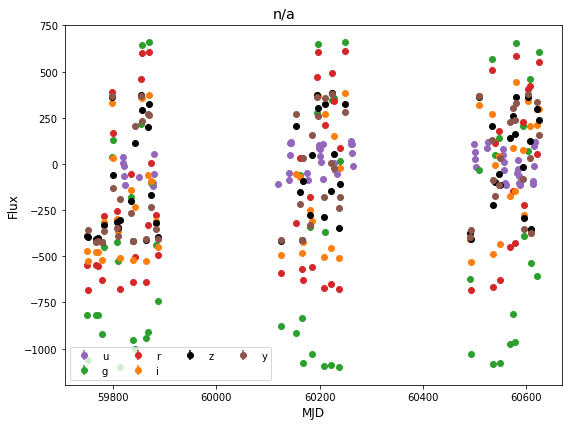

In [33]:
# ... continuing from above...
object_id = object_df['object_id']
criteria = train["object_id"] == object_id
result = train[criteria]
### the definition of MyLightCurve is at bottom of this notebook !!!!
myLightCurve =  MyLightCurve(result)
myLightCurve.plot_multicolor_lc()

In [31]:
### define MyLightCurve - this is used to plot light curves

from collections import OrderedDict
import scipy.stats as spstat

class MyLightCurve(object):
    '''Light curve object for PLAsTiCC formatted data'''
    
    _passbands = OrderedDict([(0,'C4'),\
                              (1,'C2'),\
                              (2,'C3'),\
                              (3,'C1'),\
                              (4,'k'),\
                              (5,'C5')])
    
    _pbnames = ['u','g','r','i','z','y']
    
    def __init__(self, dataframe):
        '''Read in light curve data'''

        self.DFlc     = dataframe
        self.filename = 'n/a'
        self._finalize()
     
    # this is some simple code to demonstrate how to calculate features on these multiband light curves
    # we're not suggesting using these features specifically
    # there also might be additional pre-processing you do before computing anything
    # it's purely for illustration
    def _finalize(self):
        '''Store individual passband fluxes as object attributes'''
        # in this example, we'll use the weighted mean to normalize the features
        weighted_mean = lambda flux, dflux: np.sum(flux*(flux/dflux)**2)/np.sum((flux/dflux)**2)
        
        # define some functions to compute simple descriptive statistics
        normalized_flux_std = lambda flux, wMeanFlux: np.std(flux/wMeanFlux, ddof = 1)
        normalized_amplitude = lambda flux, wMeanFlux: (np.max(flux) - np.min(flux))/wMeanFlux
        normalized_MAD = lambda flux, wMeanFlux: np.median(np.abs((flux - np.median(flux))/wMeanFlux))
        beyond_1std = lambda flux, wMeanFlux: sum(np.abs(flux - wMeanFlux) > np.std(flux, ddof = 1))/len(flux)
        
        for pb in self._passbands:
            ind = self.DFlc['passband'] == pb
            pbname = self._pbnames[pb]
            
            if len(self.DFlc[ind]) == 0:
                setattr(self, f'{pbname}Std', np.nan)
                setattr(self, f'{pbname}Amp', np.nan)
                setattr(self, f'{pbname}MAD', np.nan)
                setattr(self, f'{pbname}Beyond', np.nan)
                setattr(self, f'{pbname}Skew', np.nan)
                continue
            
            f  = self.DFlc['flux'][ind]
            df = self.DFlc['flux_err'][ind]
            m  = weighted_mean(f, df)
            
            # we'll save the measurements in each passband to simplify access.
            setattr(self, f'{pbname}Flux', f)
            setattr(self, f'{pbname}FluxUnc', df)
            setattr(self, f'{pbname}Mean', m)
            
            # compute the features
            std = normalized_flux_std(f, df)
            amp = normalized_amplitude(f, m)
            mad = normalized_MAD(f, m)
            beyond = beyond_1std(f, m)
            skew = spstat.skew(f) 
            
            # and save the features
            setattr(self, f'{pbname}Std', std)
            setattr(self, f'{pbname}Amp', amp)
            setattr(self, f'{pbname}MAD', mad)
            setattr(self, f'{pbname}Beyond', beyond)
            setattr(self, f'{pbname}Skew', skew)
        
        # we can also construct features between passbands
        pbs = list(self._passbands.keys())
        for i, lpb in enumerate(pbs[0:-1]):
            rpb = pbs[i+1]
            
            lpbname = self._pbnames[lpb]
            rpbname = self._pbnames[rpb]
            
            colname = '{}Minus{}'.format(lpbname, rpbname.upper())
            lMean = getattr(self, f'{lpbname}Mean', np.nan)
            rMean = getattr(self, f'{rpbname}Mean', np.nan)
            col = -2.5*np.log10(lMean/rMean) if lMean> 0 and rMean > 0 else -999
            setattr(self, colname, col)
    
    # this is a simple routine to visualize a light curve
    # it can plot vs the MJD array of the light curve
    # or vs an optional `phase` array that you pass 
    def plot_multicolor_lc(self, phase=None):
        '''Plot the multiband light curve'''

        fig, ax = plt.subplots(figsize=(8,6))

        
        if phase is None:
            phase = []
        if len(phase) != len(self.DFlc):
            phase = self.DFlc['mjd']
            xlabel = 'MJD'
        else:
            xlabel = 'Phase'
            
        for i, pb in enumerate(self._passbands):
            pbname = self._pbnames[pb]
            ind = self.DFlc['passband'] == pb
            if len(self.DFlc[ind]) == 0:
                continue
            ax.errorbar(phase[ind], 
                     self.DFlc['flux'][ind],
                     self.DFlc['flux_err'][ind],
                     fmt = 'o', color = self._passbands[pb], label = f'{pbname}')
        ax.legend(ncol = 4, frameon = True)
        ax.set_xlabel(f'{xlabel}', fontsize='large')
        ax.set_ylabel('Flux', fontsize='large')
        fig.suptitle(self.filename, fontsize='x-large')
        fig.tight_layout(rect=[0, 0, 1, 0.97])
    
    def get_features(self):
        '''Return all the features for this object'''
        variables = ['Std', 'Amp', 'MAD', 'Beyond', 'Skew']
        feats = []
        for i, pb in enumerate(self._passbands):
            pbname = self._pbnames[pb]
            feats += [getattr(self, f'{pbname}{x}', np.nan) for x in variables]
        return feats